In [16]:
import os, io, json, ast, sys, subprocess, shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import joblib

In [17]:
# --------------------------
# Settings
# --------------------------
USE_EMBEDDINGS = True            # set False to skip the embeddings variant
EMB_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
SAVE_DIR = Path("models_out"); SAVE_DIR.mkdir(parents=True, exist_ok=True)
SEP_TOKEN = "[SEP]"
MAX_FEATURES = 10_000
RANDOM_STATE = 42
CLASS_NAMES = ["unsat", "sat"]   # 0 -> unsat, 1 -> sat

fname = "syllogictic.csv" if "syllogictic.csv" in uploaded else list(uploaded.keys())[0]
print("Using file:", fname)


Using file: syllogistic (1).csv


In [18]:
# --------------------------
# Helpers
# --------------------------
def normalize_label(v):
    if isinstance(v, str):
        s = v.strip().lower()
        if s in {"sat","satisfiable","1","true"}:  return 1
        if s in {"unsat","unsatisfiable","0","false"}:  return 0
    if isinstance(v, (int, np.integer)):
        if v in (0,1): return int(v)
    raise ValueError(f"Unrecognized label: {v!r}")

def parse_sent(cell, sep=SEP_TOKEN):
    if isinstance(cell, list): return f" {sep} ".join(cell)
    if isinstance(cell, str):
        s = cell.strip()
        if (s.startswith("[") and s.endswith("]")) or (s.startswith("(") and s.endswith(")")):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, list) and all(isinstance(x, str) for x in parsed):
                    return f" {sep} ".join(parsed)
            except Exception:
                pass
        return s
    return str(cell)

def metrics(y_true, y_pred, avg="macro"):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=avg, zero_division=0)
    return {"accuracy": acc, f"precision_{avg}": p, f"recall_{avg}": r, f"f1_{avg}": f1}

def plot_cm(cm, class_names, title, normalize=False, save_path=None):
    cm_plot = cm.astype(float)
    if normalize:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0.0] = 1.0
        cm_plot = cm_plot / row_sums

    plt.figure(figsize=(4.5, 4))
    im = plt.imshow(cm_plot, interpolation='nearest', cmap='Blues', aspect='equal')
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    # annotate cells
    thresh = cm_plot.max() / 2.0 if cm_plot.max() > 0 else 0.5
    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            val = f"{cm_plot[i, j]:.2f}" if normalize else f"{int(cm_plot[i, j])}"
            plt.text(j, i, val,
                     ha="center", va="center",
                     color="white" if cm_plot[i, j] > thresh else "black", fontsize=11)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=180, bbox_inches="tight")
    plt.show()


In [19]:
# --------------------------
# Load data
# --------------------------
df = pd.read_csv(fname)
label_col = "label" if "label" in df.columns else "sat" if "sat" in df.columns else None
if label_col is None: raise ValueError("No label column found. Expected 'label' or 'sat'.")
if "sentences" not in df.columns: raise ValueError("Expected a 'sentences' column.")

df["y"] = df[label_col].apply(normalize_label).astype(int)
df["text"] = df["sentences"].apply(parse_sent)

X = df["text"].tolist()
y = df["y"].to_numpy()

Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)


In [20]:
# --------------------------
# TF-IDF model spaces
# --------------------------
spaces = {}
vec_tfidf = [("tfidf", TfidfVectorizer(ngram_range=(1, 2), max_features=MAX_FEATURES))]

spaces["logreg_tfidf"] = (
    Pipeline(vec_tfidf + [("clf", LogisticRegression(solver="liblinear", max_iter=1000, random_state=RANDOM_STATE))]),
    {"clf__C": [0.01, 0.1, 1.0, 10.0]},
    -1
)
spaces["svm_linear_tfidf"] = (
    Pipeline(vec_tfidf + [("clf", LinearSVC())]),
    {"clf__C": [0.1, 1.0]},
    -1
)
spaces["decision_tree_tfidf"] = (
    Pipeline(vec_tfidf + [("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))]),
    {"clf__criterion": ["gini", "entropy"], "clf__max_depth": [10, 20, None]},
    -1
)
spaces["random_forest_tfidf"] = (
    Pipeline(vec_tfidf + [("clf", RandomForestClassifier(random_state=RANDOM_STATE))]),
    {"clf__criterion": ["gini", "entropy"], "clf__n_estimators": [100, 200], "clf__max_features": ["sqrt"]},
    -1
)

summary = {"file": fname, "results": {}}


Using file: syllogistic (1).csv

=== logreg_tfidf ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__C': 10.0}

Validation report:
              precision    recall  f1-score   support

           0     0.7497    0.9381    0.8334      1469
           1     0.4383    0.1337    0.2049       531

    accuracy                         0.7245      2000
   macro avg     0.5940    0.5359    0.5191      2000
weighted avg     0.6670    0.7245    0.6665      2000



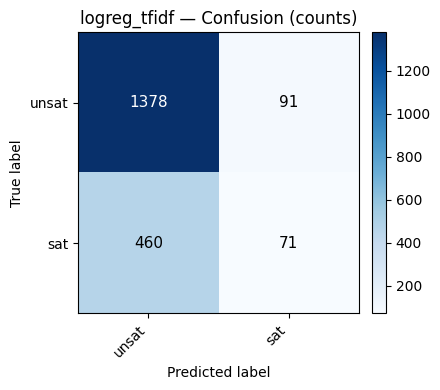

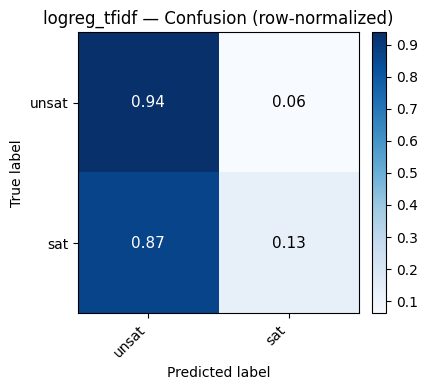


=== svm_linear_tfidf ===
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params: {'clf__C': 1.0}

Validation report:
              precision    recall  f1-score   support

           0     0.7487    0.9530    0.8386      1469
           1     0.4692    0.1149    0.1846       531

    accuracy                         0.7305      2000
   macro avg     0.6089    0.5340    0.5116      2000
weighted avg     0.6745    0.7305    0.6649      2000



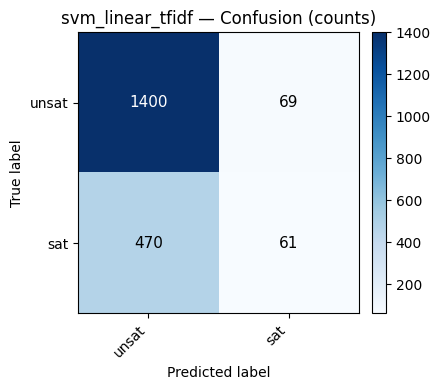

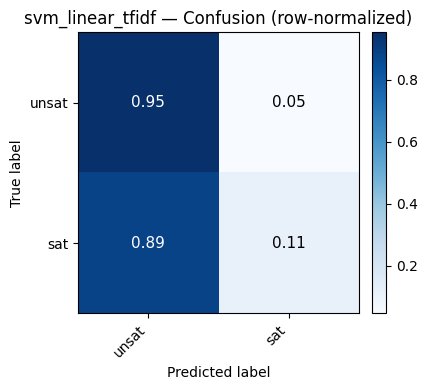


=== decision_tree_tfidf ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 20}

Validation report:
              precision    recall  f1-score   support

           0     0.7877    0.8434    0.8146      1469
           1     0.4614    0.3710    0.4113       531

    accuracy                         0.7180      2000
   macro avg     0.6245    0.6072    0.6129      2000
weighted avg     0.7010    0.7180    0.7075      2000



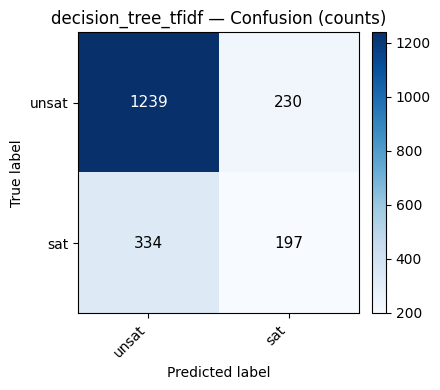

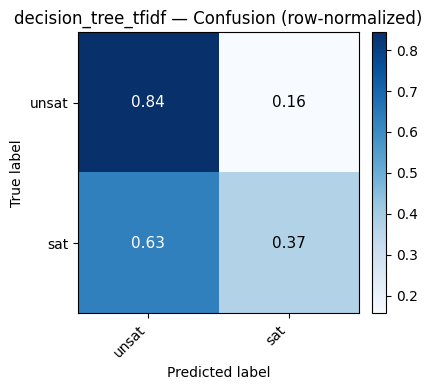


=== random_forest_tfidf ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'clf__n_estimators': 100}

Validation report:
              precision    recall  f1-score   support

           0     0.7611    0.9782    0.8561      1469
           1     0.7143    0.1507    0.2488       531

    accuracy                         0.7585      2000
   macro avg     0.7377    0.5644    0.5525      2000
weighted avg     0.7487    0.7585    0.6949      2000



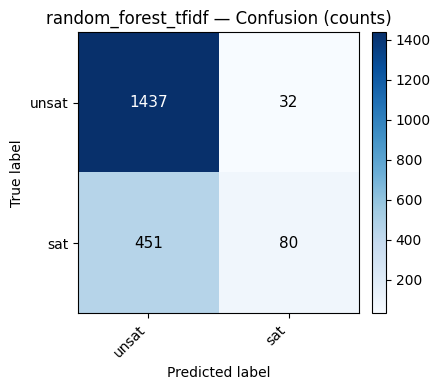

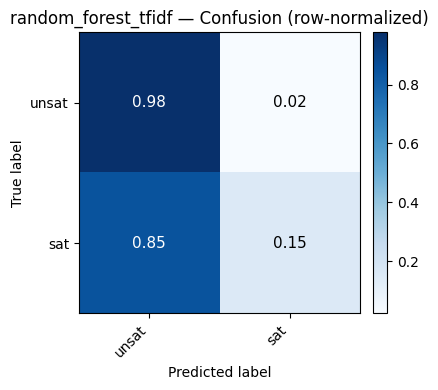

In [14]:
# --------------------------
# Train TF-IDF models
# --------------------------
from sklearn.model_selection import GridSearchCV

for name, (pipe, grid, n_jobs) in spaces.items():
    print(f"\n=== {name} ===")
    gs = GridSearchCV(pipe, grid, scoring="f1", cv=3, n_jobs=n_jobs, verbose=1, error_score="raise")
    gs.fit(Xtr, ytr)
    best = gs.best_estimator_
    print("Best params:", gs.best_params_)

    yhat = best.predict(Xval)
    print("\nValidation report:")
    print(classification_report(yval, yhat, digits=4))

    cm = confusion_matrix(yval, yhat, labels=[0,1])

    # Visual + save (counts)
    cm_counts_path = SAVE_DIR / f"cm_{name}_counts.png"
    plot_cm(cm, CLASS_NAMES, f"{name} — Confusion (counts)", normalize=False, save_path=cm_counts_path)

    # Visual + save (normalized)
    cm_norm_path = SAVE_DIR / f"cm_{name}_normalized.png"
    plot_cm(cm, CLASS_NAMES, f"{name} — Confusion (row-normalized)", normalize=True, save_path=cm_norm_path)

    model_path = SAVE_DIR / f"{name}.joblib"
    joblib.dump(best, model_path)

    summary["results"][name] = {
        "best_params": gs.best_params_,
        "metrics_macro": metrics(yval, yhat, "macro"),
        "metrics_binary": metrics(yval, yhat, "binary"),
        "confusion_matrix": cm.tolist(),
        "cm_counts_path": str(cm_counts_path),
        "cm_normalized_path": str(cm_norm_path),
        "model_path": str(model_path)
    }


=== logreg_emb (precomputed) ===


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'C': 1.0}

Validation report:
              precision    recall  f1-score   support

           0     0.7790    0.9142    0.8412      1469
           1     0.5435    0.2825    0.3717       531

    accuracy                         0.7465      2000
   macro avg     0.6612    0.5984    0.6065      2000
weighted avg     0.7165    0.7465    0.7166      2000



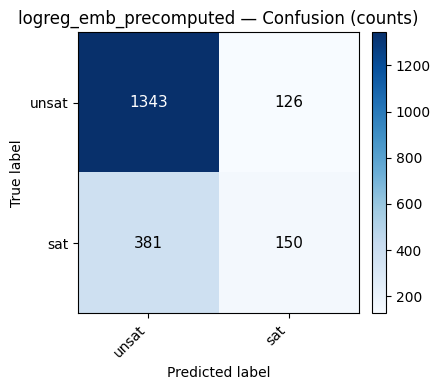

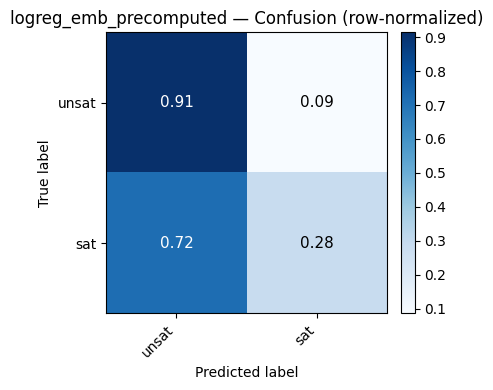

In [15]:
# --------------------------
# Embeddings variant (SAFE): precompute embeddings, then grid over the classifier
# --------------------------
if USE_EMBEDDINGS:
    try:
        from sentence_transformers import SentenceTransformer
    except Exception:
        print("Installing sentence-transformers ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "sentence-transformers"])
        from sentence_transformers import SentenceTransformer

    print("\n=== logreg_emb (precomputed) ===")
    st_model = SentenceTransformer(EMB_MODEL_NAME)  # uses CPU/GPU automatically

    def embed(texts, batch_size=256):
        return st_model.encode(
            list(texts),
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=False
        )

    # Precompute once
    Xtr_emb = embed(Xtr)
    Xval_emb = embed(Xval)

    # Optional scaling
    scaler = StandardScaler(with_mean=True)
    Xtr_emb_s = scaler.fit_transform(Xtr_emb)
    Xval_emb_s = scaler.transform(Xval_emb)

    # Grid search on classifier only
    logreg = LogisticRegression(solver="liblinear", max_iter=1000, random_state=RANDOM_STATE)
    param_grid = {"C": [0.01, 0.1, 1.0, 10.0]}
    gs_emb = GridSearchCV(logreg, param_grid, scoring="f1", cv=3, n_jobs=-1, verbose=1, error_score="raise")
    gs_emb.fit(Xtr_emb_s, ytr)
    print("Best params:", gs_emb.best_params_)

    yhat = gs_emb.predict(Xval_emb_s)
    print("\nValidation report:")
    print(classification_report(yval, yhat, digits=4))

    cm = confusion_matrix(yval, yhat, labels=[0,1])

    # Visual + save for embeddings
    cm_counts_path = SAVE_DIR / f"cm_logreg_emb_precomputed_counts.png"
    plot_cm(cm, CLASS_NAMES, "logreg_emb_precomputed — Confusion (counts)", normalize=False, save_path=cm_counts_path)

    cm_norm_path = SAVE_DIR / f"cm_logreg_emb_precomputed_normalized.png"
    plot_cm(cm, CLASS_NAMES, "logreg_emb_precomputed — Confusion (row-normalized)", normalize=True, save_path=cm_norm_path)

    # Save classifier + scaler as a bundle
    bundle = {"scaler": scaler, "clf": gs_emb.best_estimator_, "embedding_model": EMB_MODEL_NAME}
    model_path = SAVE_DIR / "logreg_emb_precomputed.joblib"
    joblib.dump(bundle, model_path)

    summary["results"]["logreg_emb_precomputed"] = {
        "best_params": gs_emb.best_params_,
        "metrics_macro": metrics(yval, yhat, "macro"),
        "metrics_binary": metrics(yval, yhat, "binary"),
        "confusion_matrix": cm.tolist(),
        "cm_counts_path": str(cm_counts_path),
        "cm_normalized_path": str(cm_norm_path),
        "model_path": str(model_path)
    }

In [21]:
# --------------------------
# Save summary + zip for download
# --------------------------
rep_path = SAVE_DIR / "report.json"
with open(rep_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
print(f"\nSaved models, CMs & report to: {SAVE_DIR.resolve()}")
print(json.dumps(summary, indent=2)[:1200], "...")

zip_path = shutil.make_archive("models_out", "zip", root_dir=SAVE_DIR)
print(f"\nZipped: {zip_path}")
try:
    files.download(zip_path)
except Exception:
    print("If the download prompt doesn't appear, use the Files pane to download 'models_out.zip'.")


Saved models, CMs & report to: /content/models_out
{
  "file": "syllogistic (1).csv",
  "results": {}
} ...

Zipped: /content/models_out.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>